• Q1: Why is the KL Divergence term important in the VAE loss function?
The KL Divergence term is important in the VAE loss function because it acts as a regularizer for the latent space. While the reconstruction loss focuses on how accurately the model replicates input data, the KL Divergence ensures the learned latent distribution approximates a standard Gaussian distribution. Allowing for more meaningful data generation from any point within the latent space.

• Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?
The reparameterization trick enables backpropagation through the stochastic layers of a VAE by transforming the non-differentiable operation of random sampling into a differentiable function.

• Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?
A VAE uses probabilistic latent space instead of a fixed one to transform the model into a generative model capable of creating diverse data from the original input. By using the mean and varience from the data as distributions.

• Q4: What role does KL Divergence play in ensuring a smooth latent space?
By minimizing the difference between the learned distribution and a standard normal distribution, the KL Divergence ensures the latent space is smooth and continuousm, acting as a counterbalance to the reconstruction loss.

In [ ]:
# !pip install torch
# !pip install torchvision

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [41]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [42]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [43]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [44]:
# Load MNIST dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Epoch 1, Loss: 165.04610322265626
Epoch 2, Loss: 122.58844931640625
Epoch 3, Loss: 115.37940986328125
Epoch 4, Loss: 112.1620875813802
Epoch 5, Loss: 110.29564742838542
Epoch 6, Loss: 109.10143206380208
Epoch 7, Loss: 108.16122908528646
Epoch 8, Loss: 107.40920043945313
Epoch 9, Loss: 106.95793738606771
Epoch 10, Loss: 106.51292146809895


In [45]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.show()




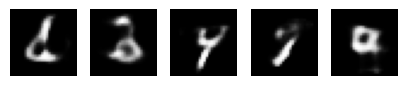

In [46]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
generate_images(vae, num_images=5, latent_dim=20)

### Task 1

In [47]:
import torch.nn as nn

# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_channels, image_size, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.image_size = image_size
        self.input_channels = input_channels
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.flattened_size = 256 * (image_size // (2**4)) * (image_size // (2**4))
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(-1, self.flattened_size)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 256, self.image_size // (2**4), self.image_size // (2**4))
        return self.decoder_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [49]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Instantiate the VAE model with CIFAR-10 specific parameters
vae = VAE(input_channels=3, image_size=32, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    BCE = nn.functional.binary_cross_entropy(recon_x_flat, x_flat, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)

Epoch 1, Loss: 1931.9003021875
Epoch 2, Loss: 1856.3622771875
Epoch 3, Loss: 1843.79541375
Epoch 4, Loss: 1838.86551125
Epoch 5, Loss: 1836.2970025
Epoch 6, Loss: 1835.32688625
Epoch 7, Loss: 1834.430076875
Epoch 8, Loss: 1833.83979
Epoch 9, Loss: 1833.0721559375
Epoch 10, Loss: 1832.6292796875


In [51]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20, image_size=32, input_channels=3):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim)
        generated_images = model.decode(z).cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        img = generated_images[i]
        if input_channels == 1:
            # Grayscale image (MNIST)
            axs[i].imshow(img.view(image_size, image_size), cmap='gray')
        else:
            # Color image (CIFAR-10)
            axs[i].imshow(img.view(input_channels, image_size, image_size).permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()

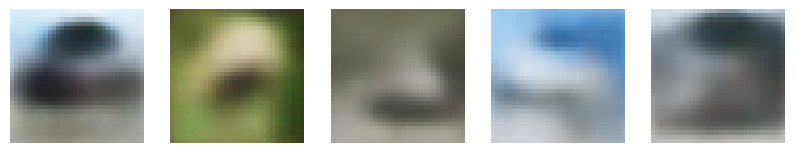

In [52]:
generate_images(vae, num_images=5, latent_dim=20, image_size=32, input_channels=3)

*   **Fully Connected VAE on MNIST:**
    *   Generated digits showed reasonable clarity and were generally recognizable, capturing the overall structure well.
    *   Images were are slightly blurry.
*   **Convolutional VAE on CIFAR-10:**
    *   Generated images were abstract, blurry, they appeared as colorful splotches rather than recognizable objects from the CIFAR-10 dataset.




### Task 2

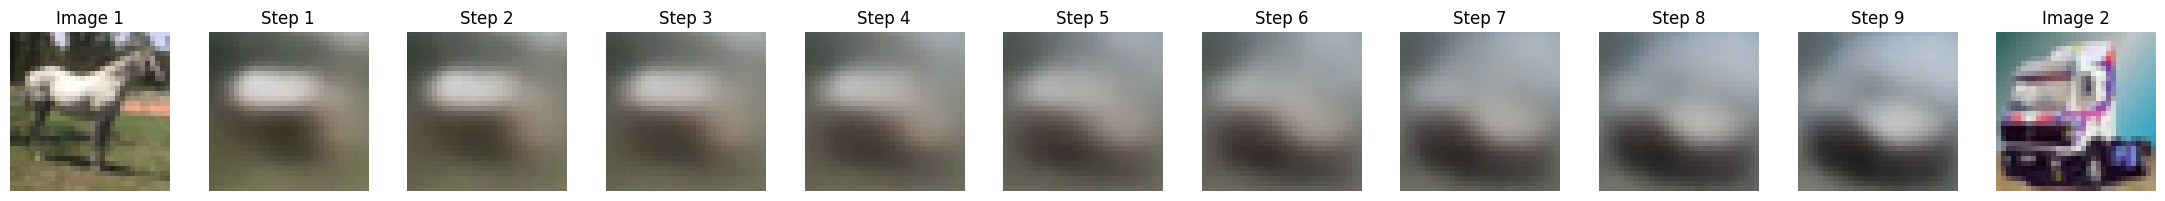

In [53]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


vae.eval()

# Load CIFAR-10 test dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Select two random images from the test set
def get_random_images(loader, num_images=2):
    images = []
    for i, (img, _) in enumerate(loader):
        images.append(img)
        if i == num_images - 1:
            break
    return torch.cat(images, dim=0)

# Get two random images for interpolation
random_images = get_random_images(test_loader, num_images=2)
image1 = random_images[0:1]
image2 = random_images[1:2]

# Function to perform latent space interpolation
def interpolate_latent_space(model, img1, img2, num_steps=10):
    with torch.no_grad():
        # Encode the two images
        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)


        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

        interpolated_images = []
        for i in range(num_steps + 1):
            alpha = i / num_steps

            interpolated_z = alpha * z2 + (1 - alpha) * z1

            decoded_img = model.decode(interpolated_z)
            interpolated_images.append(decoded_img)

        return torch.cat(interpolated_images, dim=0)

# Perform interpolation
num_interpolation_steps = 8
interpolated_output = interpolate_latent_space(vae, image1, image2, num_steps=num_interpolation_steps)

# Display the results
def plot_interpolated_images(original_img1, original_img2, interpolated_imgs, image_size=32, input_channels=3):
    total_images = interpolated_imgs.shape[0]
    fig, axs = plt.subplots(1, total_images, figsize=(total_images * 2, 2))

    # Display the first original image
    axs[0].imshow(original_img1.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].axis('off')
    axs[0].set_title('Image 1')

    # Display interpolated images
    for i in range(interpolated_imgs.shape[0] - 2):
        axs[i+1].imshow(interpolated_imgs[i+1].permute(1, 2, 0).cpu().numpy())
        axs[i+1].axis('off')
        axs[i+1].set_title(f'Step {i+1}')

    # Display the second original image
    axs[total_images - 1].imshow(original_img2.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[total_images - 1].axis('off')
    axs[total_images - 1].set_title('Image 2')

    plt.tight_layout()
    plt.show()


all_images_to_plot = [image1.squeeze(0)] + [img.squeeze(0) for img in interpolated_output]


combined_interpolated = torch.cat((image1, interpolated_output, image2), dim=0)
plot_interpolated_images(image1, image2, combined_interpolated, image_size=32, input_channels=3)


### Task 3



In [54]:
from torchvision import transforms, datasets
import torch


celeba_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
data_dir = './data_celeba'


celeba_dataset = datasets.CelebA(root=data_dir,
                                 split='train',
                                 transform=celeba_transform,
                                 download=True)

batch_size = 64
celeba_loader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2)

print(f"CelebA dataset loaded with {len(celeba_dataset)} images.")
print(f"DataLoader created with batch size {batch_size}.")

# Verify a batch shape
for images, _ in celeba_loader:
    print(f"Shape of one batch: {images.shape}")
    break

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=61e0967a-4a49-46d1-8745-61537f361ff2
To: /content/data_celeba/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:15<00:00, 93.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data_celeba/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 99.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data_celeba/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 21.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data_celeba/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 271MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /con

CelebA dataset loaded with 162770 images.
DataLoader created with batch size 64.
Shape of one batch: torch.Size([64, 3, 64, 64])


In [56]:
input_channels_celeba = 3
image_size_celeba = 64
hidden_dim_celeba = 256
latent_dim_celeba = 128

vae_celeba = VAE(input_channels=input_channels_celeba, image_size=image_size_celeba, hidden_dim=hidden_dim_celeba, latent_dim=latent_dim_celeba)
optimizer_celeba = optim.Adam(vae_celeba.parameters(), lr=1e-3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_celeba.to(device)

VAE model 'vae_celeba' moved to: cpu


In [ ]:
import torch.nn.functional as F

def loss_function_celeba(recon_x, x, mu, logvar):
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    x_normalized_for_bce = (x_flat + 1) / 2
    BCE = F.binary_cross_entropy(recon_x_flat, x_normalized_for_bce, reduction='sum')


    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_celeba(model, train_loader, optimizer, epoch, device, log_interval=100):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function_celeba(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Train the VAE model on the CelebA dataset
print(f"Starting training for {num_epochs_celeba} epochs on {device}...")
for epoch in range(1, num_epochs_celeba + 1):
    train_celeba(vae_celeba, celeba_loader, optimizer_celeba, epoch, device)
print("Training complete.")

Starting training for 10 epochs on cpu...
Train Epoch: 1 [0/162770 (0%)]	Loss: 8522.091797
Train Epoch: 1 [6400/162770 (4%)]	Loss: 7196.634766
Train Epoch: 1 [12800/162770 (8%)]	Loss: 7164.688965
Train Epoch: 1 [19200/162770 (12%)]	Loss: 6915.236328
Train Epoch: 1 [25600/162770 (16%)]	Loss: 6624.758301
Train Epoch: 1 [32000/162770 (20%)]	Loss: 6310.785645
Train Epoch: 1 [38400/162770 (24%)]	Loss: 6517.134766
Train Epoch: 1 [44800/162770 (28%)]	Loss: 6539.317871
Train Epoch: 1 [51200/162770 (31%)]	Loss: 6530.673828
Train Epoch: 1 [57600/162770 (35%)]	Loss: 6393.476074
Train Epoch: 1 [64000/162770 (39%)]	Loss: 6361.747559
Train Epoch: 1 [70400/162770 (43%)]	Loss: 6318.271484
Train Epoch: 1 [76800/162770 (47%)]	Loss: 6444.040527
Train Epoch: 1 [83200/162770 (51%)]	Loss: 6526.301758
Train Epoch: 1 [89600/162770 (55%)]	Loss: 6525.973633
Train Epoch: 1 [96000/162770 (59%)]	Loss: 6234.449707
Train Epoch: 1 [102400/162770 (63%)]	Loss: 6335.950684
Train Epoch: 1 [108800/162770 (67%)]	Loss: 6466

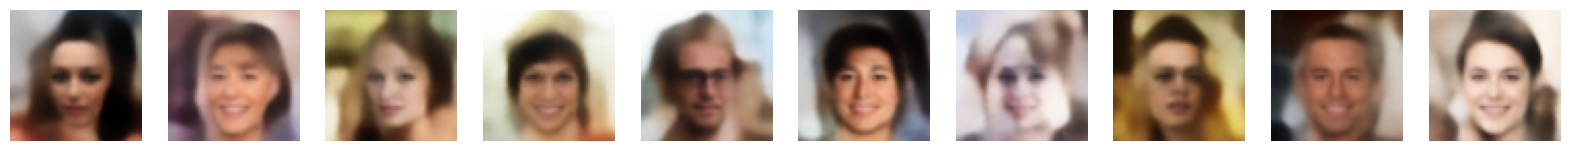

In [ ]:
generate_images(vae_celeba, num_images=10, latent_dim=latent_dim_celeba, image_size=image_size_celeba, input_channels=input_channels_celeba)

Selected image1 shape: torch.Size([1, 3, 64, 64])
Selected image2 shape: torch.Size([1, 3, 64, 64])
Interpolated output tensor shape: torch.Size([9, 3, 64, 64])


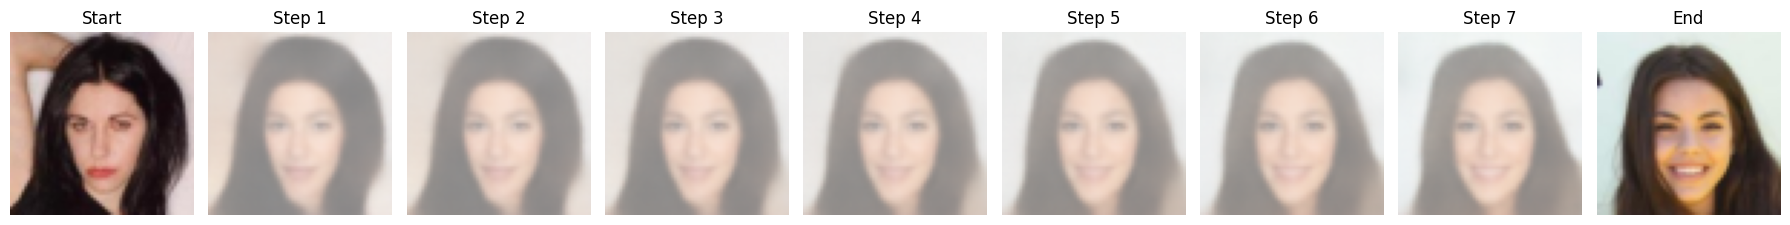

In [ ]:
vae_celeba.eval()

def get_random_images_celeba(loader, num_images=2):
    images = []
    for i, (img, _) in enumerate(loader):
        images.append(img)
        if i == num_images - 1:
            break
    return torch.cat(images[:num_images], dim=0).to(device)
celeba_test_dataset = datasets.CelebA(root=data_dir,
                                 split='test',
                                 transform=celeba_transform,
                                 download=True)

celeba_test_loader = torch.utils.data.DataLoader(celeba_test_dataset,
                                                batch_size=1,
                                                shuffle=True,
                                                num_workers=2)

random_images_celeba = get_random_images_celeba(celeba_test_loader, num_images=2)
image1 = random_images_celeba[0:1]
image2 = random_images_celeba[1:2]

print(f"Selected image1 shape: {image1.shape}")
print(f"Selected image2 shape: {image2.shape}")


def interpolate_latent_space_celeba(model, img1, img2, num_steps=10):
    with torch.no_grad():

        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)


        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

        interpolated_images = []

        for i in range(num_steps + 1):
            alpha = i / num_steps
            interpolated_z = alpha * z2 + (1 - alpha) * z1


            decoded_img = model.decode(interpolated_z)
            interpolated_images.append(decoded_img)


        return torch.cat(interpolated_images, dim=0)


num_interpolation_steps = 8
interpolated_output_celeba = interpolate_latent_space_celeba(vae_celeba, image1, image2, num_steps=num_interpolation_steps)

print(f"Interpolated output tensor shape: {interpolated_output_celeba.shape}")


def plot_interpolated_images_celeba(original_img1, original_img2, interpolated_imgs, image_size, input_channels):

    total_images_to_display = interpolated_imgs.shape[0]

    fig, axs = plt.subplots(1, total_images_to_display, figsize=(total_images_to_display * 2, 2.5))

    for i in range(total_images_to_display):
        if i == 0:

            img_to_plot = original_img1.squeeze(0).cpu()
            title = 'Start'
        elif i == total_images_to_display - 1:

            img_to_plot = original_img2.squeeze(0).cpu()
            title = 'End'
        else:

            img_to_plot = interpolated_imgs[i].cpu()
            title = f'Step {i}'


        img_to_plot = (img_to_plot + 1) / 2


        axs[i].imshow(img_to_plot.permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(title)

    plt.tight_layout()
    plt.show()


plot_interpolated_images_celeba(image1, image2, interpolated_output_celeba, image_size_celeba, input_channels_celeba)


### Data Analysis Key Findings
*   Latent space interpolation was performed by encoding two random CelebA test images, linearly interpolating between their latent representations, and decoding the intermediate vectors. This showed a smooth transition between the two original faces, confirming the continuity of the latent space.

